# Solving Maxwell's equations with convolutional neural networks

In [1]:
import h5py

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from angler import Simulation

from datasets.generators import *
from models.utils import pbar

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, ConvLSTM2D, Reshape, Permute

Using TensorFlow backend.


In [2]:
make_batch(perm_ellipse, "ellipses")

In [3]:
data = load_batch("datasets/test.hdf5", "ellipses")

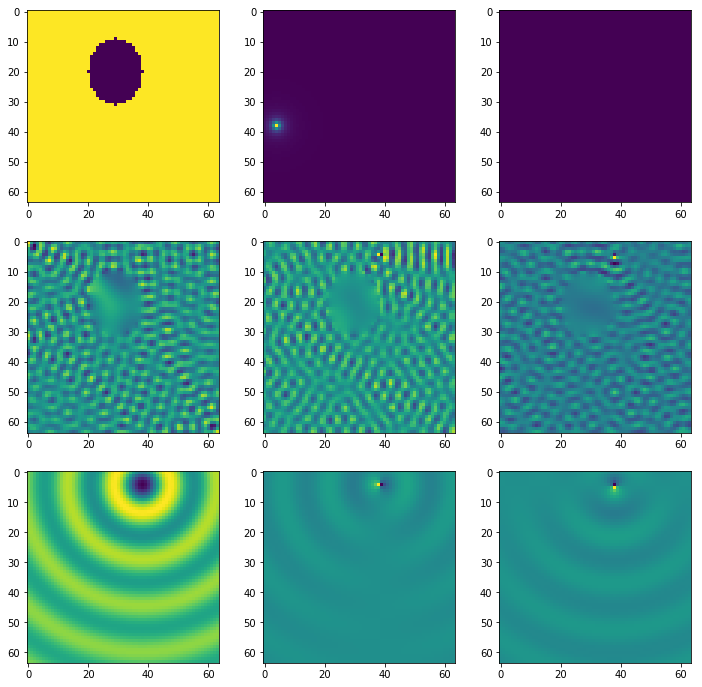

In [4]:
# Show a random data point in the batch
n = np.random.randint(0,500)
f, axarr = plt.subplots(3,3, figsize=(12,12))
axarr[0,0].imshow(data["epsilons"][n])
axarr[0,1].imshow(data["proximities"][n])
axarr[0,2].imshow(np.zeros((64,64)))
axarr[1,0].imshow(np.real(data["Ez"][n]))
axarr[1,1].imshow(np.real(data["Hx"][n]))
axarr[1,2].imshow(np.real(data["Hy"][n]))
axarr[2,0].imshow(np.real(data["Ez_vac"][n]))
axarr[2,1].imshow(np.real(data["Hx_vac"][n]))
axarr[2,2].imshow(np.real(data["Hy_vac"][n]))
plt.show()

## PyTorch model

In [31]:
# Device configuration
device = torch.device('cpu')

class PermittivityDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, hdf5_file, batch_name):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"]
        self.proximities = data["proximities"]
        self.Hx = data["Hx"]
        self.Hy = data["Hy"]
        self.Ez = data["Ez"]
        self.Hx_vac = data["Hx_vac"]
        self.Hy_vac = data["Hy_vac"]
        self.Ez_vac = data["Ez_vac"]

    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        data = torch.tensor([
            self.epsilons[i] - 1,
#             self.proximities[i],
            np.real(self.Ez_vac[i]),
            np.real(self.Hx_vac[i]),
            np.real(self.Hy_vac[i])
        ]).float()
        
        label = torch.tensor([
#             np.real(self.Ez[i][16:48, 16:48]),
            np.real(self.Hx[i][16:48, 16:48]),
            np.real(self.Ez[i][16:48, 16:48]),
            np.real(self.Hy[i][16:48, 16:48])
        ]).float()
        
        return data, label


permittivity_data = PermittivityDataset("datasets/test.hdf5", "ellipses")
train_size = int(0.9 * len(permittivity_data))
test_size = len(permittivity_data) - train_size
train_data, test_data = random_split(permittivity_data, [train_size, test_size])
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
#         conv_channels = [16, 32, 64, 64, 64, 128, 64, 1]
#         kernel_sizes = [11, 11, 5, 5, 3, 3, 1, 1]

        self.input_channels = 4
        self.output_channels = 3
        
        conv_channels = [16, 32, 64, 64, 64, 128, 64, 3]
        kernel_sizes = [11, 11, 5, 5, 3, 3, 1, 1]

#         conv_channels = [32, 64, 64, 64, 128, 64, 3]
#         kernel_sizes = [11, 5, 5, 3, 3, 1, 1]
        
        layers = []
        
        in_channels=self.input_channels # number of input channels
        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            layers.append(nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0), nn.ReLU()))
            in_channels = out_channels
        
        self.convolutions = nn.ModuleList(layers)
        
    def forward(self, x):
        out = x
        for layer in self.convolutions:
            out = layer(out)
#         out = out.reshape((batch_size, 32, 32, self.output_channels))
        return out

model = ConvNet().to(device)

# Hyperparameters
num_epochs = 1
batch_size = 25
learning_rate = 0.001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1.0)


# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    
    for data, labels in pbar(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

In [32]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
data_list = []
labels_list = []
outputs_list = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        data_list.append(data)
        labels_list.append(labels)
        outputs_list.append(outputs)

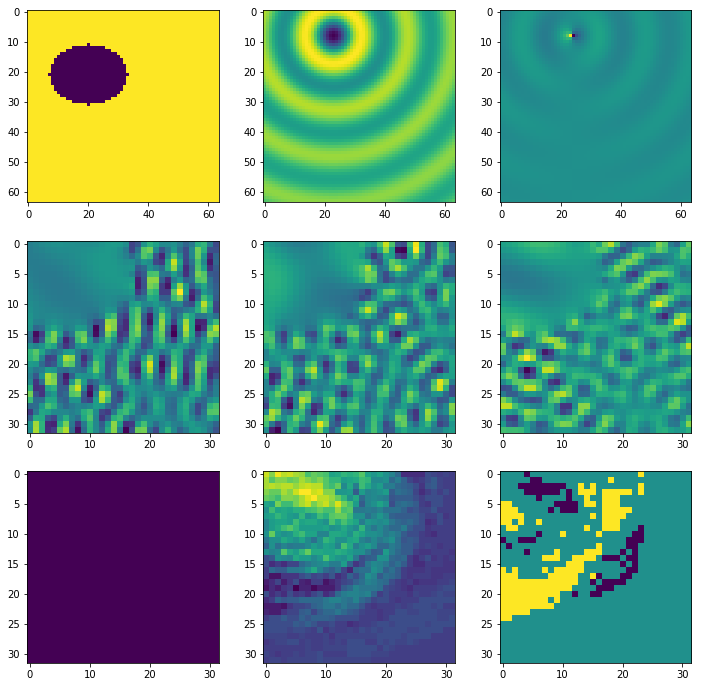

In [33]:
n = np.random.randint(0,2)
m = np.random.randint(0,batch_size)
eps, Ez_vac, Hx_vac, Hy_vac = data_list[n][m]
Ez_true, Hx_true, Hy_true = labels_list[n][m]
Ez_pred, Hx_pred, Hy_pred = outputs_list[n][m]

f, axarr = plt.subplots(3,3, figsize=(12,12))
axarr[0,0].imshow(eps)
axarr[0,1].imshow(Ez_vac)
axarr[0,2].imshow(Hx_vac)
axarr[1,0].imshow(Ez_true)
axarr[1,1].imshow(Hx_true)
axarr[1,2].imshow(Hy_true)
axarr[2,0].imshow(Ez_pred)
axarr[2,1].imshow(Hx_pred)
axarr[2,2].imshow(Hy_pred)
plt.show()

## Keras Model

In [3]:
# inputs = Input(shape=(64, 64, 1))#, 2))

# x = Conv2D(16, kernel_size=(11, 11), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
# x = Conv2D(32, kernel_size=(11, 11), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# outputs = Reshape((32, 32))(x)

# model = Model(inputs=inputs, outputs=outputs)



# inputs = Input(shape=(64, 64, 2))

# x = Conv2D(16, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
# x = Conv2D(32, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(128,kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(64, kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# x = Conv2D(1,  kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
# outputs = Reshape((32, 32))(x)

# model = Model(inputs=inputs, outputs=outputs)


# inputs = Input(shape=(64, 64, 1))
# x = Conv2D(1, kernel_size=11, data_format='channels_last', activation='relu', padding="same")(inputs)
# outputs = Reshape((64, 64))(x)


inputs = Input(shape=(64, 64, 1))

x = Conv2D(16, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(inputs)
x = Conv2D(32, kernel_size=11, data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=5,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(128,kernel_size=3,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(64, kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
x = Conv2D(1,  kernel_size=1,  data_format='channels_last', activation='relu', kernel_regularizer=keras.regularizers.l2())(x)
outputs = Reshape((32, 32))(x)

model = Model(inputs=inputs, outputs=outputs)

In [4]:
model.compile(loss=keras.losses.mean_squared_logarithmic_error,
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 16)        1952      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        61984     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 64)        102464    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [5]:
# x_data = np.stack((permittivities, proximities), axis=-1)
x_data = np.expand_dims(permittivities, axis=-1)
y_data = np.abs(Ez)[:,16:48, 16:48]
# y_data_shit = permittivities[:,16:48, 16:48]

In [7]:
history = model.fit(x_data, y_data,
                    epochs=1,
                    verbose=1,
                    validation_split = 0.1,
                    callbacks=[keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq=32)])

Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 38s 42ms/step - loss: 2.2610 - acc: 0.5139 - val_loss: 1.1847 - val_acc: 0.5347


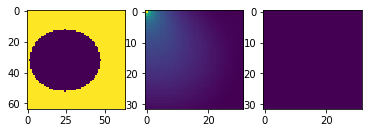

In [9]:
N = np.random.randint(0,1000)
x_pred = x_data[N:N+1]
y_real = y_data[N:N+1]

y_pred = model.predict(x_pred)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(x_pred[0,:,:,0])
# axarr[1].imshow(x_pred[0,16:48,16:48,0])
axarr[1].imshow(y_real[0])
axarr[2].imshow(y_pred[0])

In [13]:
np.max(y_real)

0.37050513960805986

In [14]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()